<a href="https://colab.research.google.com/github/SARU230/PES-energy-scan-by-changing-atomic-coordinates/blob/main/change_of_energy_in_PES_from_log_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

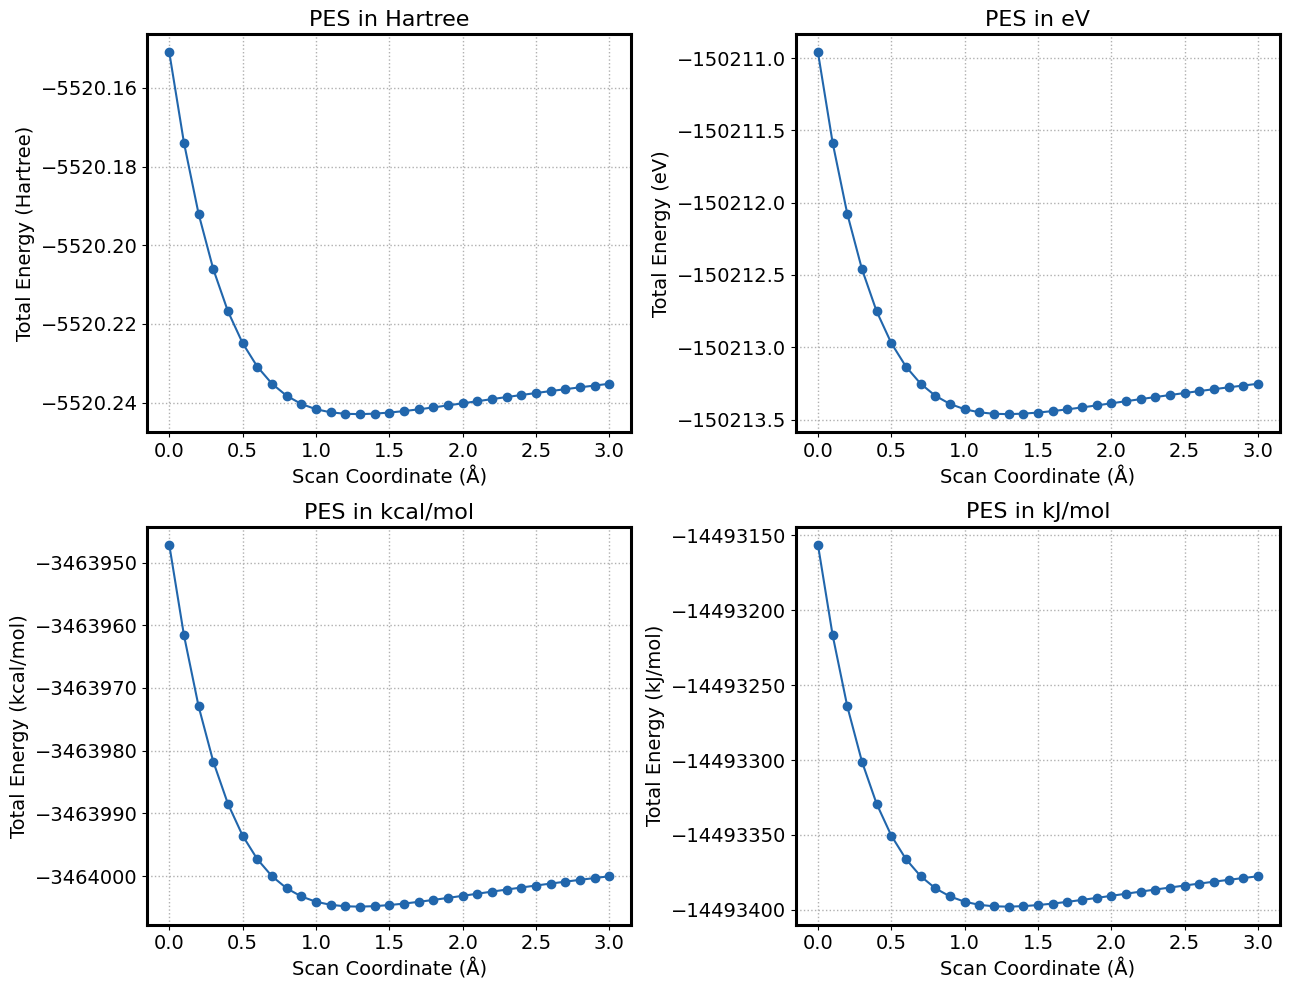

<Figure size 800x600 with 0 Axes>

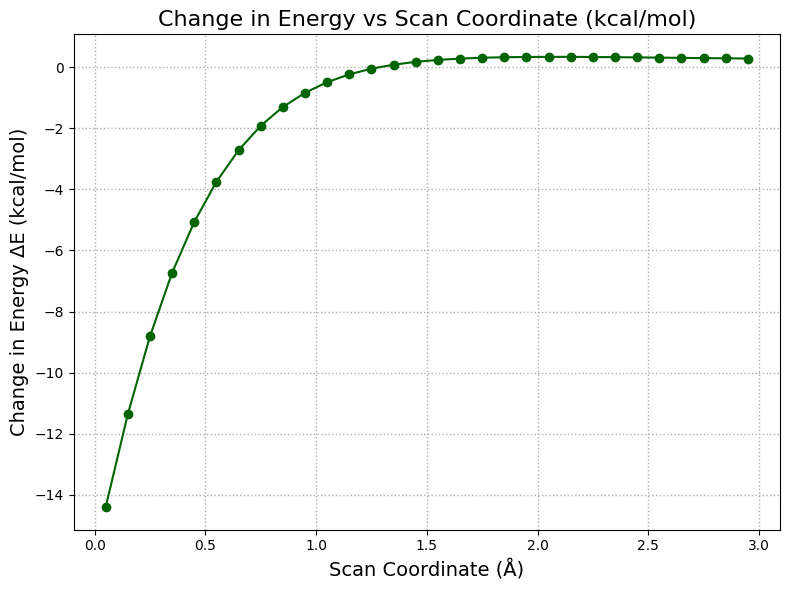

In [ ]:
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, MultipleLocator

CONFIG = {
    'logfile': 'input.log',
   # 'x_offset': -11.157244,        ##   for slide in TTP -11.157244    TP -13.524828
    'x_offset': -13.304043,                # for TTP -11.156616, for TP -7.537048  slide out
    'x_to_angstrom': 1.0,
    'figure_size': (13, 10),
    'frame_width': 2.2,
    'font_size': 14,
    'title_fontsize': 16,
    'grid': True,
    'abs_energy_color': '#2166ac',
    'box_on': True,
    'axis_limits': {
        'Hartree': {'x': None, 'y': None},
        'eV': {'x': None, 'y': None},
        'kcal/mol': {'x': None, 'y': None},
        'kJ/mol': {'x': None, 'y': None},
        'delta_e': {'x': (None), 'y': None}  # Set your desired axis limits here
    },
    'major_tick_spacing': {
        'Hartree': {'x': None, 'y': None},
        'eV': {'x': None, 'y': None},
        'kcal/mol': {'x': None, 'y': None},
        'kJ/mol': {'x': None, 'y': None},
        'delta_e': {'x': None, 'y': None}  # Tick spacing for ΔE plot (e.g., every 1 on x, every 2 on y)
    },
    'reverse_x': False,
    'reverse_y': {
        'Hartree': False,
        'eV': False,
        'kcal/mol': False,
        'kJ/mol': False,
        'delta_e': False
    }
}

HARTREE_TO_EV = 27.211386245981
HARTREE_TO_KCAL = 627.5095
HARTREE_TO_KJMOL = 2625.5

# --- Scan coordinates from summary table ---
with open(CONFIG['logfile'], 'r') as f:
    lines = f.readlines()

scan_coords = []
summary_found = False
for i, line in enumerate(lines):
    if 'Summary of the potential surface scan' in line:
        summary_found = True
        summary_start = i + 1
        break
if not summary_found:
    raise RuntimeError('No summary table found!')

for line in lines[summary_start:]:
    if line.strip() == '' or line.strip().startswith('-') or line.strip().startswith('N'):
        continue
    if line.strip().startswith('----'):
        break
    parts = line.strip().split()
    if len(parts) == 3:
        try:
            coord = float(parts[1])
            scan_coords.append(coord)
        except ValueError:
            continue

# --- SCF Done energies from log ---
scf_energies = []
for line in lines:
    match = re.search(r"SCF Done:.*=\s*([-0-9.]+)\s*A\.U\.", line)
    if match:
        energy = float(match.group(1))
        scf_energies.append(energy)

# Trim to same length
n = min(len(scan_coords), len(scf_energies))
scan_coords, scf_energies = scan_coords[:n], scf_energies[:n]

coords = [(x + CONFIG['x_offset']) * CONFIG['x_to_angstrom'] for x in scan_coords]

units = {
    'Hartree': lambda x: x,
    'eV': lambda x: x * HARTREE_TO_EV,
    'kcal/mol': lambda x: x * HARTREE_TO_KCAL,
    'kJ/mol': lambda x: x * HARTREE_TO_KJMOL,
}

fig, axes = plt.subplots(2, 2, figsize=CONFIG['figure_size'])
plt.subplots_adjust(wspace=0.35, hspace=0.35)
ax_titles = ["PES in Hartree", "PES in eV", "PES in kcal/mol", "PES in kJ/mol"]
energy_labels = ["Total Energy (Hartree)", "Total Energy (eV)", "Total Energy (kcal/mol)", "Total Energy (kJ/mol)"]

for i, (ax, (unit_label, conv)) in enumerate(zip(axes.flat, units.items())):
    y_abs = [conv(e) for e in scf_energies]
    label = list(units.keys())[i]
    ax.plot(coords, y_abs, 'o-', color=CONFIG['abs_energy_color'])
    ax.set_xlabel('Scan Coordinate (Å)', fontsize=CONFIG['font_size'])
    ax.set_ylabel(energy_labels[i], fontsize=CONFIG['font_size'])
    ax.set_title(ax_titles[i], fontsize=CONFIG['title_fontsize'])
    ax.tick_params(axis='both', labelsize=CONFIG['font_size'])
    sf = ScalarFormatter()
    sf.set_useOffset(False)
    sf.set_scientific(False)
    ax.yaxis.set_major_formatter(sf)
    ax.xaxis.set_major_formatter(sf)
    xlim = CONFIG['axis_limits'][label]['x']
    ylim = CONFIG['axis_limits'][label]['y']
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    x_major = CONFIG['major_tick_spacing'][label]['x']
    y_major = CONFIG['major_tick_spacing'][label]['y']
    if x_major is not None:
        ax.xaxis.set_major_locator(MultipleLocator(x_major))
    if y_major is not None:
        ax.yaxis.set_major_locator(MultipleLocator(y_major))
    if CONFIG['reverse_x']:
        ax.invert_xaxis()
    if CONFIG['reverse_y'][label]:
        ax.invert_yaxis()
    if CONFIG['grid']:
        ax.grid(True, linestyle=':', linewidth=1)
    if CONFIG['box_on']:
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(CONFIG['frame_width'])
    else:
        for spine in ax.spines.values():
            spine.set_visible(False)
plt.tight_layout()
plt.show()

# --- Plot change in energy ΔE in kcal/mol ---
energy_kcal = [e * HARTREE_TO_KCAL for e in scf_energies]
energy_changes_kcal = [j - i for i, j in zip(energy_kcal[:-1], energy_kcal[1:])]
coord_midpoints = [(a + b) / 2 for a, b in zip(coords[:-1], coords[1:])]

plt.figure(figsize=(8, 6))
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(coord_midpoints, energy_changes_kcal, 'o-', color='darkgreen', label='Change in Energy ΔE (kcal/mol)')
ax.set_xlabel('Scan Coordinate (Å)', fontsize=CONFIG['font_size'])
ax.set_ylabel('Change in Energy ΔE (kcal/mol)', fontsize=CONFIG['font_size'])
ax.set_title('Change in Energy vs Scan Coordinate (kcal/mol)', fontsize=CONFIG['title_fontsize'])
if CONFIG['grid']:
    ax.grid(True, linestyle=':', linewidth=1)

# Use limits and tick spacing from config
xlim = CONFIG['axis_limits']['delta_e']['x']
ylim = CONFIG['axis_limits']['delta_e']['y']
if xlim is not None:
    ax.set_xlim(xlim)
if ylim is not None:
    ax.set_ylim(ylim)

x_major = CONFIG['major_tick_spacing']['delta_e']['x']
y_major = CONFIG['major_tick_spacing']['delta_e']['y']
if x_major is not None:
    ax.xaxis.set_major_locator(MultipleLocator(x_major))
if y_major is not None:
    ax.yaxis.set_major_locator(MultipleLocator(y_major))

if CONFIG['reverse_x']:
    ax.invert_xaxis()
if CONFIG['reverse_y']['delta_e']:
    ax.invert_yaxis()

plt.tight_layout()
plt.show()
